# Burnt area mapping using chunk_polygon on UDF

The classical Normalized Burnt Ratio(NBR) difference is performed on a chunk of polygons in this notebook. You can find ways to develop your process and use chunk_polygon in a use case. The method followed in this notebook to compute DNBR is inspired by [UN SPIDER's](https://github.com/UN-SPIDER/burn-severity-mapping-EO) recommended practices.

In [12]:
# import necessary packages
import openeo
import json
from pathlib import Path
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors

# connect with the backend
eoconn = openeo.connect("openeo.vito.be").authenticate_oidc()

Authenticated using refresh token.


Users can choose from various backends available [here](https://hub.openeo.org/) to connect to their preferred backend. While OpenID Connect (OIDC) is recommended for authentication, it may sometimes be complicated to use. If you encounter issues connecting with OIDC, you can use the basic authentication method explained [here](https://openeo.org/documentation/1.0/authentication.html#openid-connect).

In [2]:
# function to load geojson file
def read_json(path: Path) -> dict:
    with open(path) as input:
        field = json.load(input)
        input.close()
    return field

To use the data collection, a user must use the correct backend with the data collection. Then, using [load_collection](https://open-eo.github.io/openeo-python-client/datacube_construction.html#the-load-collection-process), they can specify bands, temporal extent (i.e. interested time interval) and even spatial extent. In this example, we have loaded the entire collection so that the process (including UDF) can later be applied to spatial chunks. 

In [3]:
# load datacube for beforeand after fire
before_date = ["2021-01-12", "2021-03-12"]
after_date = ["2021-05-18", "2021-07-18"]

before_cube = eoconn.load_collection(
    "SENTINEL2_L1C_SENTINELHUB", temporal_extent=before_date, bands=["B08", "B12"]
)
after_cube = eoconn.load_collection(
    "SENTINEL2_L1C_SENTINELHUB",
    temporal_extent=after_date,
    bands=["B08", "B12"],
)

Here, we presented a method to create and use UDF as an openEO feature. Similarly, user can create their UDF as needed to apply to their data cube. More information on [UDF](https://open-eo.github.io/openeo-python-client/udf.html). The reason to create a UDF openEO is similar to creating a function in general Python, i.e. to avoid recursive script.

Our UDF computes the Normalised Burnt Ratio (NBR) from the selected band by performing simple band computation and returns an NBR datacube.

In [4]:
# Create a UDF object from inline source code for computing nbr
my_code = """
from openeo.udf import XarrayDataCube


def apply_datacube(cube: XarrayDataCube, context: dict) -> XarrayDataCube:
    # access the underlying xarray
    inarr = cube.get_array()

    # nbr
    nir = inarr.loc[:,'B08']
    swir = inarr.loc[:,'B12']
    nbr = (nir-swir)/(nir+swir)
    
    # extend bands dim
    nbr=nbr.expand_dims(dim='bands', axis=-3).assign_coords(bands=['nbr'])
    
    # wrap back to datacube and return
    return XarrayDataCube(nbr)
"""
udf_process = lambda data: data.run_udf(udf=my_code, runtime="python")

We used the chunk_polygon method to apply our UDF over a spatial chunk of the datacube. In the case of a simple process that does not require UDF, you can directly load your spatial extent in the dataset. 

In [8]:
# specify aoi chunks
spatial_param = read_json("cal_aoi_v2.geojson")

# compute nbr for pre and post datacube
pre_nbr = before_cube.apply_polygon(polygons=spatial_param, process=udf_process)
post_nbr = after_cube.apply_polygon(polygons=spatial_param, process=udf_process)

Furthermore, since we loaded our collection for specific time intervals, it can include multiple time dimensions. Thus, [reduce_dimension](https://processes.openeo.org/#reduce_dimension) applies a reducer to a data cube dimension by collapsing all the pixel values along the time dimension into an output value computed by the reducer.

In [9]:
# perform time dimension reduction
pre_n = pre_nbr.reduce_dimension(dimension="t", reducer="mean")
post_n = post_nbr.reduce_dimension(dimension="t", reducer="mean")

# find the difference between pre and post image
sub = post_n - pre_n

Users can select from various backends available [here](https://hub.openeo.org/) to connect to their preferred backend. While OpenID Connect (OIDC) is recommended for authentication, it may sometimes be complicated. If you encounter issues connecting with OIDC, you can use the primary authentication method explained [here](https://openeo.org/documentation/1.0/authentication.html#openid-connect).

In [10]:
# download your output
sub.download("sub_nbr_udf.tiff")

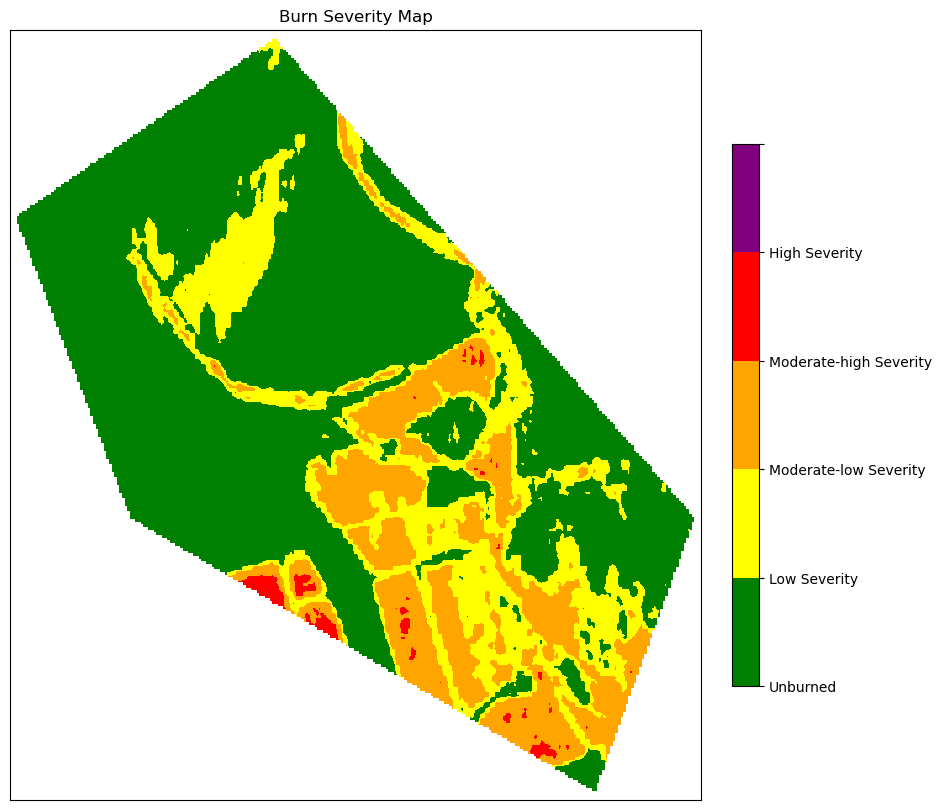

In [14]:
# set colors for plotting and classes based on UN SPIDER recommended practices

# Read the image
img = rasterio.open("sub_nbr_udf.tiff").read()

# Define the colormap and normalization
cmap = matplotlib.colors.ListedColormap(["green", "yellow", "orange", "red", "purple"])
bounds = [-0.5, 0.1, 0.27, 0.44, 0.66, 1.3]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cmap.set_over("purple")
cmap.set_under("white")

# Create the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"xticks": [], "yticks": []})
cax = ax.imshow(img[0], cmap=cmap, norm=norm)
plt.title("Burn Severity Map")

# Create the colorbar with corrected number of labels
cbar = fig.colorbar(cax, ax=ax, fraction=0.035, pad=0.04, ticks=bounds)
cbar.ax.set_yticklabels(
    [
        "Unburned",
        "Low Severity",
        "Moderate-low Severity",
        "Moderate-high Severity",
        "High Severity",
        "",
    ]
)

# Display the plot
plt.show()

The bound set for the legend are based on the description provided in the UN SPIDER guideline.